# Sychronous Generator Load Step Parameter Study

## Run

In [ ]:
%%bash
TOP=${TOP:-$(git rev-parse --show-toplevel)}
PATH=${TOP}/build/Examples/Cxx

DP_EMT_SynGenDq7odTrapez_LoadStep

In [ ]:
%%bash
TOP=${TOP:-$(git rev-parse --show-toplevel)}
PATH=${TOP}/build/Examples/Cxx

DP_EMT_SynGenDq7odODE_LoadStep

## Evaluation

In [7]:
import villas.dataprocessing.readtools as rt
from villas.dataprocessing.timeseries import TimeSeries as ts
import matplotlib.pyplot as plt
import pandas as pd

### EMT ODE

In [8]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(0,11):
        log_dir = '../../../dpsim-diss/logs/'
        log_name = log_dir+'EMT_SynGenDq7odODE_T' + str(ts_idx) + '_L' + str(load_idx) + '/' \
            'EMT_SynGenDq7odODE_T' + str(ts_idx) + '_L' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        result_list.append({'timestep': ts_idx, 'load': load_idx, 'values': ts_curr})      
        
pd_emt_ode = pd.DataFrame(result_list)

In [ ]:
pd_emt_ode

(0.09, 0.12)

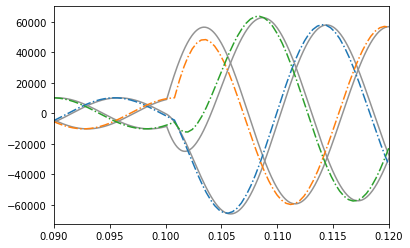

In [10]:
loadstep = 8
timestep = 1
curr = pd_emt_ode.query('timestep=='+str(timestep)+' and load=='+str(loadstep))['values'].values[0]
plt.plot(curr['i_gen_0'].time, curr['i_gen_0'].values, color = '#939393ff')
plt.plot(curr['i_gen_1'].time, curr['i_gen_1'].values, color = '#939393ff')
plt.plot(curr['i_gen_2'].time, curr['i_gen_2'].values, color = '#939393ff')

timestep = 8
curr = pd_emt_ode.query('timestep=='+str(timestep)+' and load=='+str(loadstep))['values'].values[0]
plt.plot(curr['i_gen_0_intpl'].time, curr['i_gen_0_intpl'].values, linestyle='-.')
plt.plot(curr['i_gen_1_intpl'].time, curr['i_gen_1_intpl'].values, linestyle='-.')
plt.plot(curr['i_gen_2_intpl'].time, curr['i_gen_2_intpl'].values, linestyle='-.')

#plt.xlim([0.19,0.21])
plt.xlim([0.09,0.12])
#plt.ylim([-15000,15000])

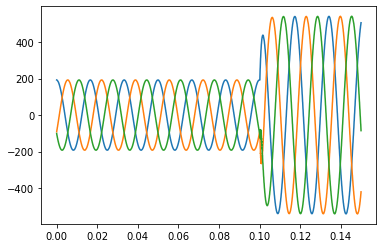

In [11]:
loadstep = 2
timestep = 2
curr = pd_emt_ode.query('timestep=='+str(1)+' and load=='+str(loadstep))['values'].values[0]
curr_ts = pd_emt_ode.query('timestep=='+str(timestep)+' and load=='+str(loadstep))['values'].values[0]
min_length = 3000 #min(curr['i_gen_0'].values.shape, curr_ts['i_gen_0_intpl'].values.shape)[0]
plt.plot(curr['i_gen_0'].time[:min_length], curr['i_gen_0'].values[:min_length] - curr_ts['i_gen_0_intpl'].values[:min_length])
plt.plot(curr['i_gen_1'].time[:min_length], curr['i_gen_1'].values[:min_length] - curr_ts['i_gen_1_intpl'].values[:min_length])
plt.plot(curr['i_gen_2'].time[:min_length], curr['i_gen_2'].values[:min_length] - curr_ts['i_gen_2_intpl'].values[:min_length])

#plt.xlim([0.09,0.15])
#plt.ylim([-2000,2000])
#plt.xlim([0.19,0.21])
#plt.ylim([-15000,15000])

In [20]:
import numpy as np

def calc_dpsim_variable_timestep_mae(ref, test_list):
    # find the minimum number of time steps available in the list of timeseries results
    min_length = ref.values.shape[0]
    for test in test_list:
        if test.values.shape[0] < min_length:
            min_length = test.values.shape[0]
    min_length = 3000
    # calculate maximum amplitude of EMT reference signal to normalize error
    max_amp = np.max(np.abs(ref.values[:min_length]))
    print('max. amplitude: ' +str(max_amp))
    # Calculate difference for each timeseries with respect to the 50µs reference
    diff_list = []
    for test in test_list:
        diff_list.append( (test.values[:min_length] - ref.values[:min_length]) ) #/ max_amp )

    # calculate mean absolute error
    mae = []
    for diff in diff_list:
        mae.append( np.sum(np.abs(diff)) / min_length )
        
    return mae, diff_list

In [21]:
mae_emt_ode_list = []

for load_idx in range(0,11): 
    pd_test_list = pd_emt_ode.query('timestep > 1 and load=='+str(load_idx))
    test_list = []
    for index, row in pd_test_list.iterrows():
        test_list.append(row['values']['i_gen_0_intpl'])
    
    ref = pd_emt_ode.query('timestep == 1 and load=='+str(load_idx)).iloc[0]['values']['i_gen_0']
    mae_emt_ode, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
    mae_emt_ode_list.append(mae_emt_ode)
    #print(mae_emt_ode)

max. amplitude: 10206.212064
max. amplitude: 20070.753708
max. amplitude: 28831.184007
max. amplitude: 36853.498417
max. amplitude: 44032.955308
max. amplitude: 50452.153918
max. amplitude: 56203.767549000004
max. amplitude: 61376.254540999995
max. amplitude: 66039.152476
max. amplitude: 70263.096653
max. amplitude: 74104.733326


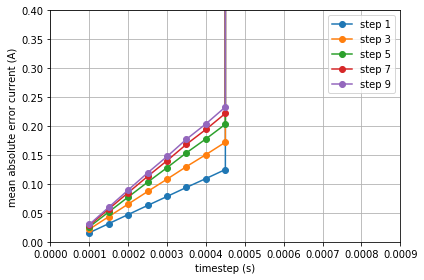

In [46]:
ref = pd_emt_ode.query('timestep == 1 and load==0').iloc[0]['values']['i_gen_0']
max_amp = np.max(np.abs(ref.values[:]))

timesteps = np.arange(2,21)*0.00005
for load_idx in range(1,11,2):  
    plt.plot(timesteps, mae_emt_ode_list[load_idx] / max_amp, 'o-', label='step '+str(load_idx))
plt.legend()
plt.ylim([0,0.4])
#plt.ylim([0,3000])
plt.xlim([0,0.0009])

plt.xlabel('timestep (s)')
plt.ylabel('mean absolute error current (A)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('emt_ode_syngen_mae.pdf')

### DP ODE

In [30]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(0,11):
        log_dir = '../../../dpsim-diss/logs/'
        log_name = log_dir+'DP_SynGenDq7odODE_T' + str(ts_idx) + '_L' + str(load_idx) + '/' \
            'DP_SynGenDq7odODE_T' + str(ts_idx) + '_L' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        ts_curr = ts.frequency_shift_list(ts_curr, 60)
        result_list.append({'timestep': ts_idx, 'load': load_idx, 'values': ts_curr})      
        
pd_dp_ode = pd.DataFrame(result_list)

In [33]:
#pd_dp_ode

In [31]:
mae_dp_ode_list = []

for load_idx in range(0,11): 
    pd_test_list = pd_dp_ode.query('timestep > 1 and load=='+str(load_idx))
    test_list = []
    for index, row in pd_test_list.iterrows():
        test_list.append(row['values']['i_gen_0_intpl_shift'])
    
    ref = pd_dp_ode.query('timestep == 1 and load=='+str(load_idx)).iloc[0]['values']['i_gen_0_shift']
    mae, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
    #print(mae)
    mae_dp_ode_list.append(mae)    

max. amplitude: 10206.212005
max. amplitude: 20070.93760241812
max. amplitude: 28831.406332371007
max. amplitude: 36853.67442715641
max. amplitude: 44033.011962272634
max. amplitude: 50452.01478787988
max. amplitude: 56203.31989856168
max. amplitude: 61375.294712196446
max. amplitude: 66037.70175003761
max. amplitude: 70260.9928481338
max. amplitude: 74101.7875095906


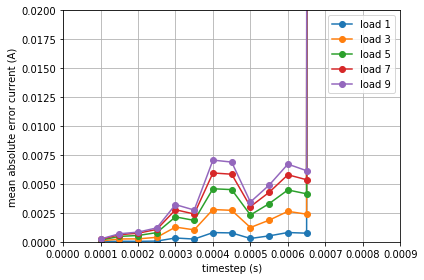

In [59]:
ref = pd_dp_ode.query('timestep == 1 and load==0').iloc[0]['values']['i_gen_0_shift']
max_amp = np.max(np.abs(ref.values[:]))

timesteps = np.arange(2,21)*0.00005
for load_idx in range(1,11,2):  
    plt.plot(timesteps, mae_dp_ode_list[load_idx] /max_amp, 'o-', label='load '+str(load_idx))
plt.legend()
plt.ylim([0,0.02])
#plt.ylim([0,200])
plt.xlim([0,0.0009])

plt.xlabel('timestep (s)')
plt.ylabel('mean absolute error current (A)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_ode_syngen_mae.pdf')

### EMT Trapez

In [48]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(0,11):
        log_name = '../../../dpsim-diss/logs/EMT_SynGenDq7odTrapez_T' + str(ts_idx) + '_L' + str(load_idx) + '/' \
            'EMT_SynGenDq7odTrapez_T' + str(ts_idx) + '_L' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)          
        result_list.append({'timestep': ts_idx, 'load': load_idx, 'values': ts_curr})      
        
pd_emt_trapez = pd.DataFrame(result_list)

In [ ]:
#pd_emt_trapez

In [49]:
mae_emt_trapez_list = []
for load_idx in range(0,11): 
    pd_test_list = pd_emt_trapez.query('timestep > 1 and load=='+str(load_idx))
    test_list = []
    for index, row in pd_test_list.iterrows():
        test_list.append(row['values']['i_gen_0_intpl'])
    
    ref = pd_emt_trapez.query('timestep == 1 and load=='+str(load_idx)).iloc[0]['values']['i_gen_0']
    mae, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
    #print(mae)
    mae_emt_trapez_list.append(mae) 

max. amplitude: 10206.212034
max. amplitude: 20070.740706
max. amplitude: 28831.172907999997
max. amplitude: 36853.482745
max. amplitude: 44032.926525999996
max. amplitude: 50452.130113
max. amplitude: 56203.743720000006
max. amplitude: 61376.222301
max. amplitude: 66039.128323
max. amplitude: 70263.07496
max. amplitude: 74104.707647


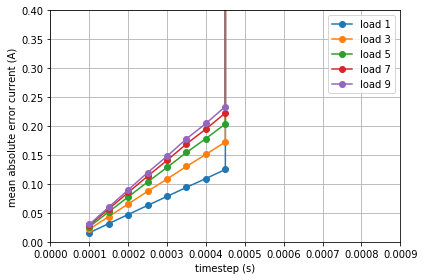

In [60]:
ref = pd_emt_trapez.query('timestep == 1 and load==0').iloc[0]['values']['i_gen_0']
max_amp = np.max(np.abs(ref.values[:]))

timesteps = np.arange(2,21)*0.00005
for load_idx in range(1,11,2):  
    plt.plot(timesteps, mae_emt_trapez_list[load_idx] / max_amp, 'o-', label='load '+str(load_idx))
plt.legend()
plt.ylim([0,0.4])
#plt.ylim([0,3000])
plt.xlim([0,0.0009])

plt.xlabel('timestep (s)')
plt.ylabel('mean absolute error current (A)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('emt_trpz_syngen_mae.pdf')

### DP Trapez

In [53]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(0,11):
        log_name = '../../../dpsim-diss/logs/DP_SynGenDq7odTrapez_T' + str(ts_idx) + '_L' + str(load_idx) + '/' \
            'DP_SynGenDq7odTrapez_T' + str(ts_idx) + '_L' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)            
        ts_curr = ts.frequency_shift_list(ts_curr, 60)
        result_list.append({'timestep': ts_idx, 'load': load_idx, 'values': ts_curr})      

pd_dp_trapez = pd.DataFrame(result_list)

In [54]:
#pd_dp_trapez

In [55]:
mae_dp_trapez_list = []
for load_idx in range(0,11): 
    pd_test_list = pd_dp_trapez.query('timestep > 1 and load=='+str(load_idx))
    test_list = []
    for index, row in pd_test_list.iterrows():
        test_list.append(row['values']['i_gen_0_intpl_shift'])
    
    ref = pd_dp_trapez.query('timestep == 1 and load=='+str(load_idx)).iloc[0]['values']['i_gen_0_shift']
    mae, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
    #print(mae)
    mae_dp_trapez_list.append(mae) 

max. amplitude: 10206.211975
max. amplitude: 20070.924706661714
max. amplitude: 28831.395835179195
max. amplitude: 36853.66075305011
max. amplitude: 44032.98724854574
max. amplitude: 50451.99810143153
max. amplitude: 56203.30661698481
max. amplitude: 61375.276624526334
max. amplitude: 66037.69579069111
max. amplitude: 70260.99339399442
max. amplitude: 74101.78803225135


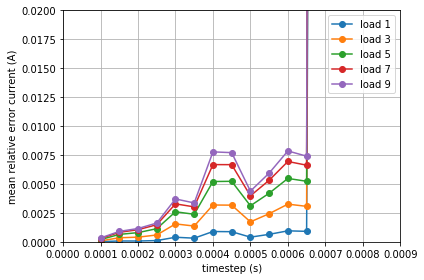

In [61]:
ref = pd_dp_trapez.query('timestep == 1 and load==0').iloc[0]['values']['i_gen_0_shift']
max_amp = np.max(np.abs(ref.values[:]))

timesteps = np.arange(2,21)*0.00005
for load_idx in range(1,11,2):  
    plt.plot(timesteps, mae_dp_trapez_list[load_idx] /max_amp, 'o-', label='load '+str(load_idx))
plt.legend()
plt.ylim([0,0.02])
plt.xlim([0,0.0009])
#plt.ylim([0,200])

plt.xlabel('timestep (s)')
plt.ylabel('mean relative error current (A)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_trpz_syngen_mae.pdf')

### Misc

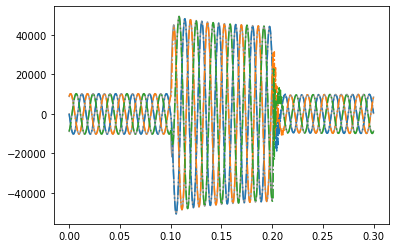

In [54]:
loadstep = 5
curr = pd_dp_trapez.query('timestep=='+str(1)+' and load=='+str(loadstep))['values'].values[0]
plt.plot(curr['i_gen_0_shift'].time, curr['i_gen_0_shift'].values, color = '#939393ff')
plt.plot(curr['i_gen_1_shift'].time, curr['i_gen_1_shift'].values, color = '#939393ff')
plt.plot(curr['i_gen_2_shift'].time, curr['i_gen_2_shift'].values, color = '#939393ff')

timestep = 12
curr = pd_dp_trapez.query('timestep=='+str(timestep)+' and load=='+str(loadstep))['values'].values[0]
plt.plot(curr['i_gen_0_intpl_shift'].time, curr['i_gen_0_intpl_shift'].values, linestyle='-.')
plt.plot(curr['i_gen_1_intpl_shift'].time, curr['i_gen_1_intpl_shift'].values, linestyle='-.')
plt.plot(curr['i_gen_2_intpl_shift'].time, curr['i_gen_2_intpl_shift'].values, linestyle='-.')